# About Dataset
The dataset contains paper titles, paper abstracts, and their subject categories collected from the arXiv portal. The collection process is available here in this notebook.

Your task is to build a text classifier model that can predict the subject areas given paper abstracts and titles. The dataset does not come with separate train, test, and validation splits. It's your responsibility to create the necessary splits to ensure a fair evaluation. You can find a baseline notebook here.

In [ ]:
# Importing necessary libraries and other algorithm techniques.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score


In [ ]:
# Imorting umap
!pip install umap-learn
import umap.umap_ as umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=1ae0f4468fb3afbae3d26ba7561efb59d1a91844e262160b9868bcd66543a263
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
# Installing the cohere
!pip install cohere
import cohere
co = cohere.Client('LzvZVP7HpeU6iTEVWSHyz5Vr27Yv32xzLtEeivUe')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 7.0.1
    Uninstalling importlib-metadata-7.0.1:
      Successfully uninstalled importlib-metadata-7.0.1


In [ ]:
!pip install plotly
import plotly.graph_objects as go

In [ ]:
# Loading the arxiv dataset using pandas and printing the first five rows.
df = pd.read_csv("/content/arxiv_data.csv")
df.head(5)

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [ ]:
# Printing the number of rows in the dataset.
print(f"There are {len(df)} rows in the dataset.")


There are 51774 rows in the dataset.


In [ ]:
#Printing the number of duplicate titles in the dataset.
duplicate_titles = sum(df["titles"].duplicated())
print(f"There are {duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [ ]:
# Printing the number of rows in the deduplicated dataset.
df = df[~df["titles"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 38972 rows in the deduplicated dataset.


In [ ]:
#Storing the unique terms if the dataset in list_unique_terms and then printing the first 10 terms
list_unique_terms = df['terms'].unique()
list_unique_terms[:10]

array(["['cs.CV', 'cs.LG']", "['cs.CV', 'cs.AI', 'cs.LG']",
       "['cs.CV', 'cs.AI']", "['cs.CV']", "['cs.CV', 'cs.HC']",
       "['cs.CV', '68U10, 62M05, 62H30, 65C20']", "['cs.CV', 'cs.NE']",
       "['cs.CV', 'cs.LG', 'eess.IV']", "['cs.CV', 'physics.geo-ph']",
       "['cs.LG']"], dtype=object)

In [ ]:
# Creating the empty list and then storing 5 random integers in rand_ints
list_dfs = []
np.random.seed(0)
rand_ints = np.random.randint(200, 201, 5)
rand_ints

array([200, 200, 200, 200, 200])

In [ ]:
# Using loop, we are appending the summaries from the first five terms of list_unique_terms to list_dfs
# And the number of summaries appended from each term is taken from rand_ints
for i, r in zip(range(5), rand_ints):
    x = df[df['terms'] == list_unique_terms[i]]
    list_dfs.append(x['summaries'][:r])

In [ ]:
# Storing the summaries in df5 and ignoring the index values and then printing the shape of df5.
df5 = pd.DataFrame(pd.concat(list_dfs, ignore_index=True))
df5.shape

(840, 1)

In [ ]:
#Creating the embeddings for clustering
embeddings = []
for i in range(0, len(df5), 96):
  texts = df5["summaries"][i:i+96].tolist()
  response = co.embed(
    texts=texts,
    model='embed-english-v3.0',
    input_type='clustering'
  )
  for j in enumerate(response.embeddings):
    embeddings.append(j[1])

In [ ]:
len(embeddings)

840

In [ ]:
#Printing the length of embeddings and adding this column to dataframe
len(embeddings)
df5['embeddings'] = embeddings
data = df5
data.head()

,summaries,embeddings
0,Stereo matching is one of the widely used tech...,"[-0.013221741, 0.004337311, -0.011726379, 0.04..."
1,"To ensure safety in automated driving, the cor...","[0.022888184, 0.01689148, 0.009208679, 0.03851..."
2,Image segmentation is a common and challenging...,"[0.026977539, 0.006450653, 0.011207581, 0.0083..."
3,The application of deep learning to medical im...,"[0.04711914, 0.0027503967, 0.031585693, 0.0167..."
4,Quantifying uncertainty in medical image segme...,"[0.021942139, 0.020645142, 0.01928711, 0.03591..."


###**Dimensionality Reduction:-**

In [ ]:
#Performing UMAP on embeddings
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
umap_embeddings = reducer.fit_transform(embeddings)
umap_embeddings

array([[-0.45999968,  6.916234  ],
       [-1.0343281 ,  7.178988  ],
       [-0.6413186 ,  7.3657928 ],
       ...,
       [-2.9288363 ,  1.828239  ],
       [-3.215039  ,  1.9731826 ],
       [-2.7955332 ,  1.6933521 ]], dtype=float32)

In [ ]:
type(umap_embeddings)

numpy.ndarray

In [ ]:
#Standardizing the umap_sembedding
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# umap_embeddings_scaled = scaler.fit_transform(umap_embeddings)
# umap_embeddings_scaled

In [ ]:
# #Performing the TSNE on embeddings and standardizing it
# embeddings = np.array(embeddings)
# tsne = TSNE(n_components=2, learning_rate=200)
# tsne_embeddings = tsne.fit_transform(embeddings)
# tsne_embeddings_scaled = scaler.fit_transform(tsne_embeddings)
# tsne_embeddings_scaled

In [ ]:
#Performing the PCA on embeddings and standardizing it
# pca = PCA(n_components=2)
# pca_embeddings = pca.fit_transform(embeddings)
# pca_embeddings_scaled = scaler.fit_transform(pca_embeddings)
# pca_embeddings_scaled

In [ ]:
# make a plot of cumulative variance explained vs number of princiapl components of embeddings

# import matplotlib.pyplot as plt
# import numpy as np
# pca = PCA()
# pca.fit(embeddings)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlim(1,10)
# plt.xlabel('Number of principal components')
# plt.ylabel('Cumulative variance explained')
# plt.show()


In [ ]:
#Performing UMAP on embeddings
# reducer = umap.UMAP(n_neighbors=25,
#     min_dist=0.01,n_components=2)
# umap_embeddings2 = reducer.fit_transform(embeddings)
# #Standardizing the umap_sembedding
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# umap_embeddings_scaled2 = scaler.fit_transform(umap_embeddings)
# umap_embeddings_scaled2

Spectral Clustering:-


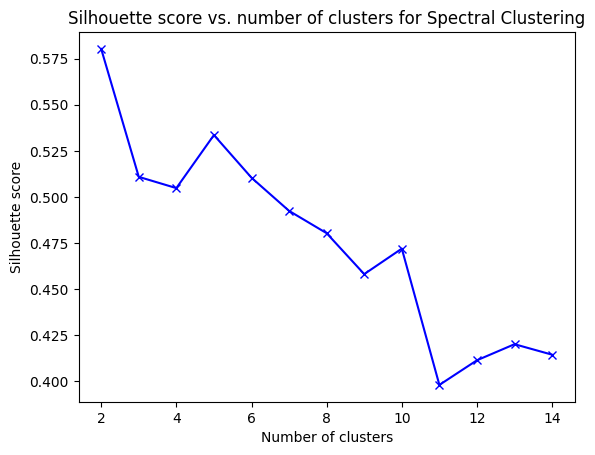

In [ ]:
#silhuette score vs number of clusters graph for umap_embeddings for spectral clustering
silhouettes = []
for n_clusters in range(2, 15):
    clusterer = SpectralClustering(n_clusters=n_clusters, affinity = 'rbf',eigen_solver='arpack')
    cluster_labels = clusterer.fit_predict(umap_embeddings)
    silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
    silhouettes.append(silhouette_avg)

plt.plot(range(2, 15), silhouettes, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. number of clusters for Spectral Clustering')
plt.show()


In [ ]:

#Performing the spectral clustering on umap_embeddings
spectral_model = SpectralClustering(n_clusters=5,affinity = 'rbf',eigen_solver='arpack' )
cluster_labels = spectral_model.fit_predict(umap_embeddings)
#Visualizing the 3d plot using plotly
fig = go.Figure(data=[go.Scatter(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1],
                               mode='markers',
                               marker=dict(
                                   size=12,
                                   color=cluster_labels,                # set color to an array/list of desired values
                                   colorscale='viridis',   # choose a colorscale
                                   opacity=0.8
                               )
                              )])

fig.show()


In [ ]:
# Calculate the number of data points in each cluster
cluster_counts = np.bincount(cluster_labels)

# Print the number of data points in each cluster
print(cluster_counts)


[156 206 117 179 182]


In [ ]:
#calculate silhuette score (Spectral Clustering) for umap_embeddings

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)

print("The average silhouette_score is :", silhouette_avg)


The average silhouette_score is : 0.5335624


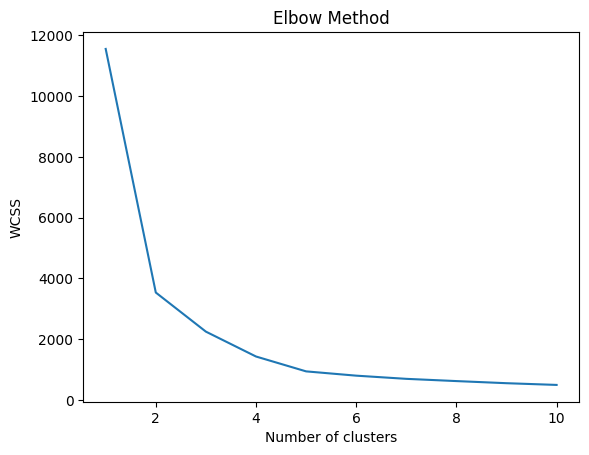

In [ ]:
#Elbow curve(Kmeans) for umap_embeddings

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
  kmeans.fit(umap_embeddings)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

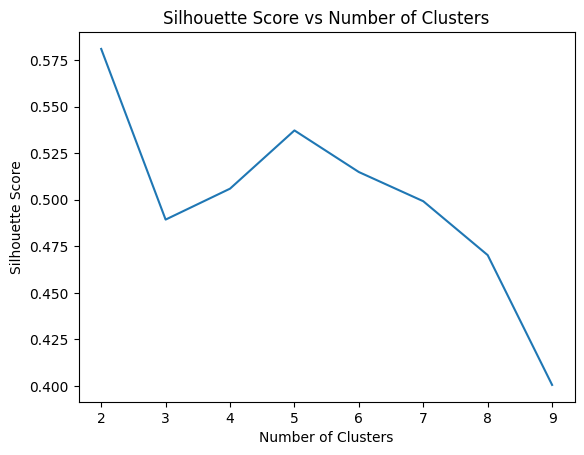

In [ ]:

# Calculate silhouette score for each number of clusters(K means) for umap_embeddings
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(umap_embeddings)
    silhouette_scores.append(silhouette_score(umap_embeddings, kmeans.labels_))

# Plot silhouette score vs number of clusters
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

In [ ]:

# KMeans on umap_embeddings
kmeans = KMeans(n_clusters=5)
kmeans.fit(umap_embeddings)

# Create a scatter plot using plotly
fig = go.Figure(data=[go.Scatter(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1],
                               mode='markers',
                               marker=dict(
                                   size=12,
                                   color=kmeans.labels_,                # set color to an array/list of desired values
                                   colorscale='Viridis',   # choose a colorscale
                                   opacity=0.8
                               )
                              )])

fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# Calculate the number of data points in each cluster
cluster_counts = np.bincount(kmeans.labels_)

# Print the number of data points in each cluster
print(cluster_counts)

In [ ]:
#silhouette score for umap_embeddings( Kmeans)

silhouette_score = silhouette_score(umap_embeddings, kmeans.labels_)
print(f"Silhouette score for KMeans on umap_embeddings_scaled2: {silhouette_score}")


Silhouette score for KMeans on umap_embeddings_scaled2: 0.5372243523597717


In [ ]:
# Creating the empty list and then storing 5 random integers in rand_ints
list_dfs = []
np.random.seed(0)
rand_ints = np.random.randint(100, 101, 15)
rand_ints

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100])

In [ ]:
# Using loop, we are appending the summaries from the first five terms of list_unique_terms to list_dfs
# And the number of summaries appended from each term is taken from rand_ints
for i, r in zip(range(15), rand_ints):
    x = df[df['terms'] == list_unique_terms[i]]
    list_dfs.append(x['summaries'][:r])

In [ ]:
# Storing the summaries in df5 and ignoring the index values and then printing the shape of df5.
df5 = pd.DataFrame(pd.concat(list_dfs, ignore_index=True))
df5.shape

(1000, 1)

In [ ]:
#Creating the embeddings for clustering
embeddingsnew = []
for i in range(0, len(df5), 96):
  texts = df5["summaries"][i:i+96].tolist()
  response = co.embed(
    texts=texts,
    model='embed-english-v3.0',
    input_type='clustering'
  )
  for j in enumerate(response.embeddings):
    embeddingsnew.append(j[1])

In [ ]:
len(embeddingsnew)

1000

In [ ]:
#Performing UMAP on embeddingsnew
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
umap_embeddingsnew = reducer.fit_transform(embeddingsnew)
umap_embeddingsnew

array([[6.0834403 , 0.95186627],
       [7.3195434 , 1.0689733 ],
       [7.6037145 , 1.2477217 ],
       ...,
       [2.440722  , 6.3087554 ],
       [2.5021975 , 7.247731  ],
       [2.4258153 , 7.1120033 ]], dtype=float32)

In [ ]:
type(umap_embeddingsnew)

numpy.ndarray

In [ ]:
# prompt: silhuette score vs number of clusters graph for umap_embeddings for spectral clustering

import matplotlib.pyplot as plt
silhouettes = []
for n_clusters in range(2, 15):
    clusterer = SpectralClustering(n_clusters=n_clusters, affinity = 'rbf',eigen_solver='arpack')
    cluster_labels = clusterer.fit_predict(umap_embeddingsnew)
    silhouette_avg = silhouette_score(umap_embeddingsnew, cluster_labels)
    silhouettes.append(silhouette_avg)

plt.plot(range(2, 15), silhouettes, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. number of clusters for Spectral Clustering')
plt.show()


In [ ]:
#Performing the spectral clustering on umap_embeddings
spectral_model = SpectralClustering(n_clusters=10,affinity = 'rbf',eigen_solver='arpack' )
cluster_labels = spectral_model.fit_predict(umap_embeddingsnew)
#Visualizing the 3d plot using plotly
fig = go.Figure(data=[go.Scatter(x=umap_embeddingsnew[:, 0], y=umap_embeddingsnew[:, 1],
                               mode='markers',
                               marker=dict(
                                   size=12,
                                   color=cluster_labels,                # set color to an array/list of desired values
                                   colorscale='viridis',   # choose a colorscale
                                   opacity=0.8
                               )
                              )])

fig.show()

In [ ]:
#calculate silhuette score (Spectral Clustering) for umap_embeddingsnew

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(umap_embeddingsnew, cluster_labels)

print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.5051846


In [ ]:
# Calculate the number of data points in each cluster
cluster_counts = np.bincount(cluster_labels)

# Print the number of data points in each cluster
print(cluster_counts)


[ 79  12 128 203 114  41 115 149  39 120]
